In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


tqdm.pandas()

In [2]:
train = pd.read_csv("../../dataset/processed/cleanDataset.csv", index_col=0)
test = pd.read_csv("../../dataset/processed/cleanTest.csv", index_col=0)

train.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,2,1.0,17.0688,22.0,Flat,bamboo or timber,bamboo/timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,Unknown/not stated,Unknown/not stated,1.0
1,3,3.0,300.2280,18.0,Flat,clay sand mixed mortar-stone/brick,wood light roof or bamboo heavy roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,5.0
3,2,18.0,56.3880,15.0,Flat,clay sand mixed mortar-stone/brick,wood light roof or bamboo light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,4.0
4,2,22.0,27.4320,17.0,Flat,clay sand mixed mortar-stone/brick,bamboo or timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,1.0
7,2,40.0,153.6192,14.0,Flat,clay mortar-stone/brick,bamboo/timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,4.0


In [3]:
dict_type_of_roof = {
    "bamboo/timber-heavy roof": "bamboo/timber heavy roof",
    "bamboo or timber light roof": "bamboo/timber-light roof",
    "bamboo/timber light roof ": "bamboo/timber-light roof",
    "bamboo or timber heavy roof": "bamboo/timber heavy roof",
    "bamboo/timber light roof": "bamboo/timber-light roof",
    "reinforced brick concrete/rcc/rbc": "reinforced cement concrete/rb/rbc"
}

train["type_of_roof"].replace(dict_type_of_roof, inplace=True)
test["type_of_roof"].replace(dict_type_of_roof, inplace=True)

In [4]:
train["type_of_roof"].value_counts()

bamboo/timber-light roof                139695
wood light roof or bamboo heavy roof     70095
wood light roof or bamboo light roof     59880
reinforced cement concrete/rb/rbc        15116
bamboo/timber heavy roof                 14353
reinforced brick slab/rcc/rbc             2468
Name: type_of_roof, dtype: int64

In [5]:
train.shape

(301607, 24)

## FE

In [6]:
from sklearn.model_selection import train_test_split

objectCol = list(train.select_dtypes(include=['object']).columns)
numCol = list(train.select_dtypes(exclude=['object']).columns)[:-1]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
y -= 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_features = numCol
categorical_features = objectCol
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder())
Preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ])

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_train = Preprocessor.fit_transform(X_rus)
X_test = Preprocessor.transform(X_test)

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from collections import Counter

x = XGBClassifier()
x.fit(X_train, y_rus)

y_pred = x.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))


0.8135337943332639


In [16]:
hasil = x.predict(Preprocessor.transform(test))

Counter(hasil).most_common()


[(4, 81969), (3, 67383), (2, 41152), (1, 35137), (0, 16441)]

<Axes: xlabel='importance'>

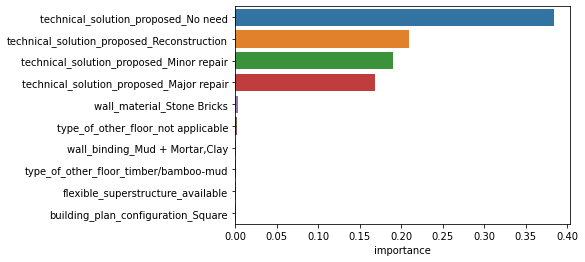

In [44]:
x_selected_features = pd.DataFrame(x.feature_importances_, numeric_features + list(Preprocessor.named_transformers_['categorical_transformer'].named_steps['onehotencoder'].get_feature_names(categorical_features)), columns=['importance'])
x_selected_features.sort_values(by='importance', ascending=False, inplace=True)


sns.barplot(x=x_selected_features.iloc[:10, 0], y=x_selected_features.iloc[:10, 0].index)

In [ ]:
x_selected_features = pd.DataFrame(
    x.feature_importances_, index=np.arange(0, 111), columns=['importance'])
x_selected_features.sort_values(by='importance', ascending=False, inplace=True)

sweet_spot = {}
for i in range(1, 112):
    X_train_selected = X_train.toarray()[:, x_selected_features[:i].index]
    X_test_selected = X_test.toarray()[:, x_selected_features[:i].index]

    x = XGBClassifier(random_state=42)
    x.fit(X_train_selected, y_rus)

    y_pred = x.predict(X_test_selected)
    skor = f1_score(y_test, y_pred, average='macro')
    print(f"{i} fitur teratas : {skor}")
    sweet_spot[i] = skor


In [72]:
sweet_spot.index

Int64Index([53, 56, 71, 76, 92, 43, 72, 51, 54, 45,
            ...
            10,  8,  9,  7,  6,  5,  4,  3,  2,  1],
           dtype='int64', length=111)

<Axes: ylabel='f1_score'>

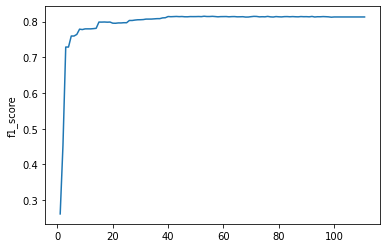

In [75]:
sweet_spot = pd.DataFrame.from_dict(sweet_spot, orient='index', columns=['f1_score'])
sweet_spot.sort_values(by='f1_score', ascending=False, inplace=True)

sns.lineplot(x=sweet_spot.index, y=sweet_spot.f1_score)

In [76]:
sweet_spot.head(10)

,f1_score
53,0.815163
56,0.814903
71,0.814801
76,0.814723
92,0.814618
43,0.814570
72,0.814569
51,0.814406
54,0.814406
45,0.814398


In [82]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

params = {'lambda_l1': 0.09918938374098207,
          'lambda_l2': 0.12147618595222721,
          'num_leaves': 81,
          'feature_fraction': 0.5375403412968238,
          'bagging_fraction': 0.9903473914047031,
          'bagging_freq': 4,
          'min_child_samples': 78}

l = LGBMClassifier(**params, random_state=69420)
l.fit(X_train, y_rus)

y_pred = l.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))


[LightGBM] [Warning] feature_fraction is set=0.5375403412968238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5375403412968238
[LightGBM] [Warning] lambda_l1 is set=0.09918938374098207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09918938374098207
[LightGBM] [Warning] bagging_fraction is set=0.9903473914047031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903473914047031
[LightGBM] [Warning] lambda_l2 is set=0.12147618595222721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12147618595222721
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.8154875337402487


In [83]:
hasil = l.predict(Preprocessor.transform(test))

Counter(hasil).most_common()

[(4.0, 80866), (3.0, 68479), (2.0, 41215), (1.0, 35119), (0.0, 16403)]

In [90]:
l_selected_features = pd.DataFrame(
    l.feature_importances_, index=np.arange(0, 111), columns=['importance'])
l_selected_features.sort_values(by='importance', ascending=False, inplace=True)

sweet_spot_l = {}
for i in range(1, 112):
    X_train_selected = X_train.toarray()[:, l_selected_features[:i].index]
    X_test_selected = X_test.toarray()[:, l_selected_features[:i].index]

    l_s = LGBMClassifier(**params, random_state=69420, verbose=-1)
    l_s.fit(X_train_selected, y_rus)

    y_pred = l_s.predict(X_test_selected)
    skor = f1_score(y_test, y_pred, average='macro')
    print(f"{i} fitur teratas : {skor}")
    sweet_spot_l[i] = skor

1 fitur teratas : 0.240841007449345
[LightGBM] [Warning] feature_fraction is set=0.5375403412968238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5375403412968238
[LightGBM] [Warning] lambda_l1 is set=0.09918938374098207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09918938374098207
[LightGBM] [Warning] bagging_fraction is set=0.9903473914047031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903473914047031
[LightGBM] [Warning] lambda_l2 is set=0.12147618595222721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12147618595222721
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
2 fitur teratas : 0.27468132300856496
[LightGBM] [Warning] feature_fraction is set=0.5375403412968238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5375403412968238
[LightGBM] [Warning] lambda_l1 is set=0.09918938374098207, reg_alpha=0.0 will be ignored. Cu

<Axes: ylabel='f1_score'>

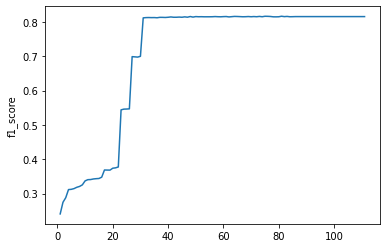

In [91]:
sweet_spot_l = pd.DataFrame.from_dict(
    sweet_spot_l, orient='index', columns=['f1_score'])
sweet_spot_l.sort_values(by='f1_score', ascending=False, inplace=True)

sns.lineplot(x=sweet_spot_l.index, y=sweet_spot_l.f1_score)

In [93]:
sweet_spot_l.head(10)


,f1_score
81,0.816644
75,0.816553
76,0.816371
73,0.816128
83,0.816127
64,0.816123
77,0.815945
65,0.815898
48,0.815818
61,0.815803


In [102]:
l = LGBMClassifier(**params, random_state=69420)
l.fit(X_train.toarray()[:, l_selected_features[:81].index], y_rus)

y_pred = l.predict(X_test.toarray()[:, l_selected_features[:81].index])

print(f1_score(y_test, y_pred, average='macro'))

[LightGBM] [Warning] feature_fraction is set=0.5375403412968238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5375403412968238
[LightGBM] [Warning] lambda_l1 is set=0.09918938374098207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09918938374098207
[LightGBM] [Warning] bagging_fraction is set=0.9903473914047031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903473914047031
[LightGBM] [Warning] lambda_l2 is set=0.12147618595222721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12147618595222721
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.816643911642682


In [100]:
from collections import Counter

In [105]:
submit_df = Preprocessor.transform(test)
submit_df = submit_df.toarray()[:, l_selected_features[:81].index]
y_pred_sub = l.predict(submit_df)

Counter(y_pred_sub).most_common()

[(4.0, 80566), (3.0, 68778), (2.0, 41213), (1.0, 35121), (0.0, 16404)]

In [106]:
submission = pd.read_csv("../../dataset/raw/sample_submission.csv")
submission["damage_grade"] = y_pred_sub + 1
submission["damage_grade"] = submission["damage_grade"].astype(int)
submission.head()

,id,damage_grade
0,0,4
1,1,5
2,2,5
3,3,4
4,4,2


In [107]:
submission.to_csv("../../dataset/submission_lgbm_feat_select_tuned_ALLAHUAKBAR.csv", index=False)